<a href="https://colab.research.google.com/github/sharmavickram/AI_ML/blob/main/CS663_vikram_2403res80_assignment_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition (NER)

**1. Introduction**

*   Named Entity Recognition (NER) is an essential task in Natural Language Processing (NLP) that involves detecting and classifying named entities (such as people, organizations, locations) in text. NER is crucial for information extraction systems, question answering, and various other applications in AI.
*   The goal of this project is to develop a Named Entity Recognition model using the dataset provided on Kaggle. The objective is to train a model that can accurately identify and classify named entities in text data.



**2. Data Description**

The dataset used is available at NER Dataset on Kaggle. It consists of annotated text data with entities tagged according to their type. The dataset includes the following columns:

**Sentence_ID**: Identifier for each sentence in the dataset.

**Word**: The word in the sentence.

**POS**: position

**Tag**: The named entity label for the word.



**Data Exploration**

To understand the dataset's structure and content, the data was explored:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
# Assuming the dataset is in CSV format. Adjust the path accordingly.
# Adjust file path and parameters as needed
file_path = 'ner_dataset.csv'

try:
    data = pd.read_csv(file_path,
                     delimiter=',',         # Specify delimiter if not comma
                     encoding='utf-8',      # Specify encoding if necessary
                     on_bad_lines='skip',   # Skip bad lines
                     low_memory=False)      # Handle large files

    print(data.head())  # Print the first few rows to check
except Exception as e:
    print(f"An error occurred: {e}")

       Sentence_ID                                               Word  \
0      Sentence: 1  ['Thousands', 'of', 'demonstrators', 'have', '...   
1     Sentence: 10  ['Iranian', 'officials', 'say', 'they', 'expec...   
2    Sentence: 100  ['Helicopter', 'gunships', 'Saturday', 'pounde...   
3   Sentence: 1000  ['They', 'left', 'after', 'a', 'tense', 'hour-...   
4  Sentence: 10000  ['U.N.', 'relief', 'coordinator', 'Jan', 'Egel...   

                                                 POS  \
0  ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...   
1  ['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...   
2  ['NN', 'NNS', 'NNP', 'VBD', 'JJ', 'NNS', 'IN',...   
3  ['PRP', 'VBD', 'IN', 'DT', 'NN', 'JJ', 'NN', '...   
4  ['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBD', 'NNP'...   

                                                 Tag  
0  ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '...  
1  ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '...  
2  ['O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', '...  
3  [

# 3. Methodology

**Preprocessing**: Load data, preprocess sentences, and encode words, POS tags, and NER tags.

**Model Definition**: Define an LSTM-based model with embedding layers.

**Training**: Train the model on the prepared data.

**Evaluation**: Evaluate model performance using classification metrics.


**3.1. Data Preprocessing**
We'll start by loading and preprocessing the dataset. You have a dataset in a structured format with sentences, words, part-of-speech (POS) tags, and NER tags.


In [ ]:
# Prepare the data
def preprocess_data(data):
    sentences = []
    words = []
    pos_tags = []
    ner_tags = []

    for sentence_id in data['Sentence_ID'].unique():
        subset = data[data['Sentence_ID'] == sentence_id]
        sentences.append(subset['Word'].tolist())
        words.append(subset['Word'].tolist())
        pos_tags.append(subset['POS'].tolist())
        ner_tags.append(subset['Tag'].tolist())

    return sentences, words, pos_tags, ner_tags

sentences, words, pos_tags, ner_tags = preprocess_data(data)

# Flatten the lists for encoding
flat_words = [item for sublist in words for item in sublist]
flat_pos_tags = [item for sublist in pos_tags for item in sublist]
flat_ner_tags = [item for sublist in ner_tags for item in sublist]

# Encode the labels
word_encoder = LabelEncoder()
pos_encoder = LabelEncoder()
ner_encoder = LabelEncoder()

word_encoder.fit(flat_words)
pos_encoder.fit(flat_pos_tags)
ner_encoder.fit(flat_ner_tags)

# Transform the data
encoded_words = [word_encoder.transform(sublist) for sublist in words]
encoded_pos_tags = [pos_encoder.transform(sublist) for sublist in pos_tags]
encoded_ner_tags = [ner_encoder.transform(sublist) for sublist in ner_tags]

# Padding sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = max(len(seq) for seq in encoded_words)

X_words = pad_sequences(encoded_words, maxlen=max_len, padding='post')
X_pos_tags = pad_sequences(encoded_pos_tags, maxlen=max_len, padding='post')
y_ner_tags = pad_sequences(encoded_ner_tags, maxlen=max_len, padding='post')

# Split the data
X_words_train, X_words_test, X_pos_tags_train, X_pos_tags_test, y_train, y_test = train_test_split(
    X_words, X_pos_tags, y_ner_tags, test_size=0.2, random_state=42
)


**3.2. Define the Model**
For NER, we use an LSTM (Long Short-Term Memory) model with embedding layers to capture semantic meaning. We combine word embeddings and POS tag embeddings to improve context understanding.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model

# Parameters
embedding_dim = 50
pos_embedding_dim = 20
lstm_units = 100
num_classes = len(ner_encoder.classes_)

# Define Inputs
input_word = Input(shape=(max_len,))
input_pos = Input(shape=(max_len,))

# Embedding layers
word_embedding = Embedding(input_dim=len(word_encoder.classes_), output_dim=embedding_dim, input_length=max_len)(input_word)
pos_embedding = Embedding(input_dim=len(pos_encoder.classes_), output_dim=pos_embedding_dim, input_length=max_len)(input_pos)

# Concatenate embeddings
concat = Concatenate(axis=-1)([word_embedding, pos_embedding])

# LSTM layer
lstm = LSTM(lstm_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)(concat)

# Output layer
output = Dense(num_classes, activation='softmax')(lstm)

# Model
model = Model(inputs=[input_word, input_pos], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 1, 50)          │            450 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 1, 20)          │            180 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 1, 70)          │              0 │ embedding_2[0][0],     │
│ (Concatenate)             │                        │                │ embedding_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 1, 100)         │         68,400 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 9)           │            909 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,939 (273.20 KB)

 Trainable params: 69,939 (273.20 KB)

 Non-trainable params: 0 (0.00 B)

**3.3. Train the Model**

In [ ]:
import numpy as np

In [ ]:
history = model.fit(
    [X_words_train, X_pos_tags_train],
    y_train[..., np.newaxis],
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - loss: 2.2021 - val_accuracy: 0.0000e+00 - val_loss: 2.1937
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.0000e+00 - loss: 2.1954 - val_accuracy: 0.0000e+00 - val_loss: 2.1967
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1667 - loss: 2.1921 - val_accuracy: 0.0000e+00 - val_loss: 2.1997
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8333 - loss: 2.1867 - val_accuracy: 0.0000e+00 - val_loss: 2.2028
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8333 - loss: 2.1826 - val_accuracy: 0.0000e+00 - val_loss: 2.2059
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 1.0000 - loss: 2.1770 - val_accuracy: 0.0000e+00 - val_loss: 2.2090
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.1723 - val_accuracy: 0.0000e+00 - val_loss: 2.2121
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 1.0000 - loss: 2.1676 - val_

**3.4. Evaluate the Model**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict([X_words_test, X_pos_tags_test])
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten the arrays for evaluation
y_test_flat = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred_classes for item in sublist]

# Decode the labels
y_test_labels = ner_encoder.inverse_transform(y_test_flat)
y_pred_labels = ner_encoder.inverse_transform(y_pred_flat)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
                                                                                                                                                                                                                 precision    recall  f1-score   support

['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']       0.00      0.00      0.00       0.0
                                                                      ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']       0.00      0.00      0.00       1.0
                                                                           ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
import numpy as np

# Convert lists to numpy arrays for easier manipulation
y_test_labels_array = np.array(y_test_labels)
y_pred_labels_array = np.array(y_pred_labels)

# Extract unique labels
unique_test_labels = np.unique(y_test_labels_array)
unique_pred_labels = np.unique(y_pred_labels_array)

# Print unique labels
print("Unique test labels:", unique_test_labels)
print("Unique predicted labels:", unique_pred_labels)

# Combine and get all unique labels
unique_labels = np.unique(np.concatenate((unique_test_labels, unique_pred_labels)))
print("All unique labels:", unique_labels)


Unique test labels: ["['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']"
 "['O', 'O', 'O', 'O', 'O', 'O', 'O']"]
Unique predicted labels: ["['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
 "['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']"]
All unique labels: ["['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
 "['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']"
 "['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O'

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Example data (replace with your actual data)
# Assuming X_words_test, X_pos_tags_test are your test features
# Assuming y_test is your true labels in encoded format
# Assuming model is your trained NER model

# Predict using the model
y_pred = model.predict([X_words_test, X_pos_tags_test])

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten the nested lists
y_test_flat = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred_classes for item in sublist]

# Decode the labels (make sure ner_encoder is fitted with your label encoder)
y_test_labels = ner_encoder.inverse_transform(y_test_flat)
y_pred_labels = ner_encoder.inverse_transform(y_pred_flat)

# Print classification report
print("Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classification Report:

                                                                                                                                                                                                                 precision    recall  f1-score   support

['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']       0.00      0.00      0.00       0.0
                                                                      ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']       0.00      0.00      0.00       1.0
                                                                           ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

**4. Evaluate Your Model**

Assuming you have already made predictions with your NER model and have the true labels and predicted labels, you can use the classification_report and confusion_matrix from sklearn to print the evaluation results.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Predict using the model
y_pred = model.predict([X_words_test, X_pos_tags_test])

# Get the predicted class indices
y_pred_classes = np.argmax(y_pred, axis=-1)

# Flatten the nested lists
y_test_flat = [item for sublist in y_test for item in sublist]
y_pred_flat = [item for sublist in y_pred_classes for item in sublist]

# Decode the labels
y_test_labels = ner_encoder.inverse_transform(y_test_flat)
y_pred_labels = ner_encoder.inverse_transform(y_pred_flat)

# Print unique labels to understand the classes present
print("Unique labels in y_test_labels:", np.unique(y_test_labels))
print("Unique labels in y_pred_labels:", np.unique(y_pred_labels))

# Extract labels present in both true and predicted labels
unique_labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
print("All unique labels present in both true and predicted labels:", unique_labels)

# Generate and print the classification report
print("Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels, labels=unique_labels, zero_division=0))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=unique_labels)

# Print the confusion matrix
print("Confusion Matrix:\n")
conf_matrix_df = pd.DataFrame(conf_matrix, index=unique_labels, columns=unique_labels)
print(conf_matrix_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Unique labels in y_test_labels: ["['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']"
 "['O', 'O', 'O', 'O', 'O', 'O', 'O']"]
Unique labels in y_pred_labels: ["['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
 "['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']"]
All unique labels present in both true and predicted labels: ["['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
 "['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', '

**5. Visualization (Optional)**

For a more intuitive understanding, you might also want to visualize the confusion matrix. This can be done using a heatmap:

**5.1. Visualizing the Classification Report**

The classification report can be visualized as a heatmap where precision, recall, and F1-score for each class are displayed. We’ll first convert the classification report to a DataFrame for easy visualization.

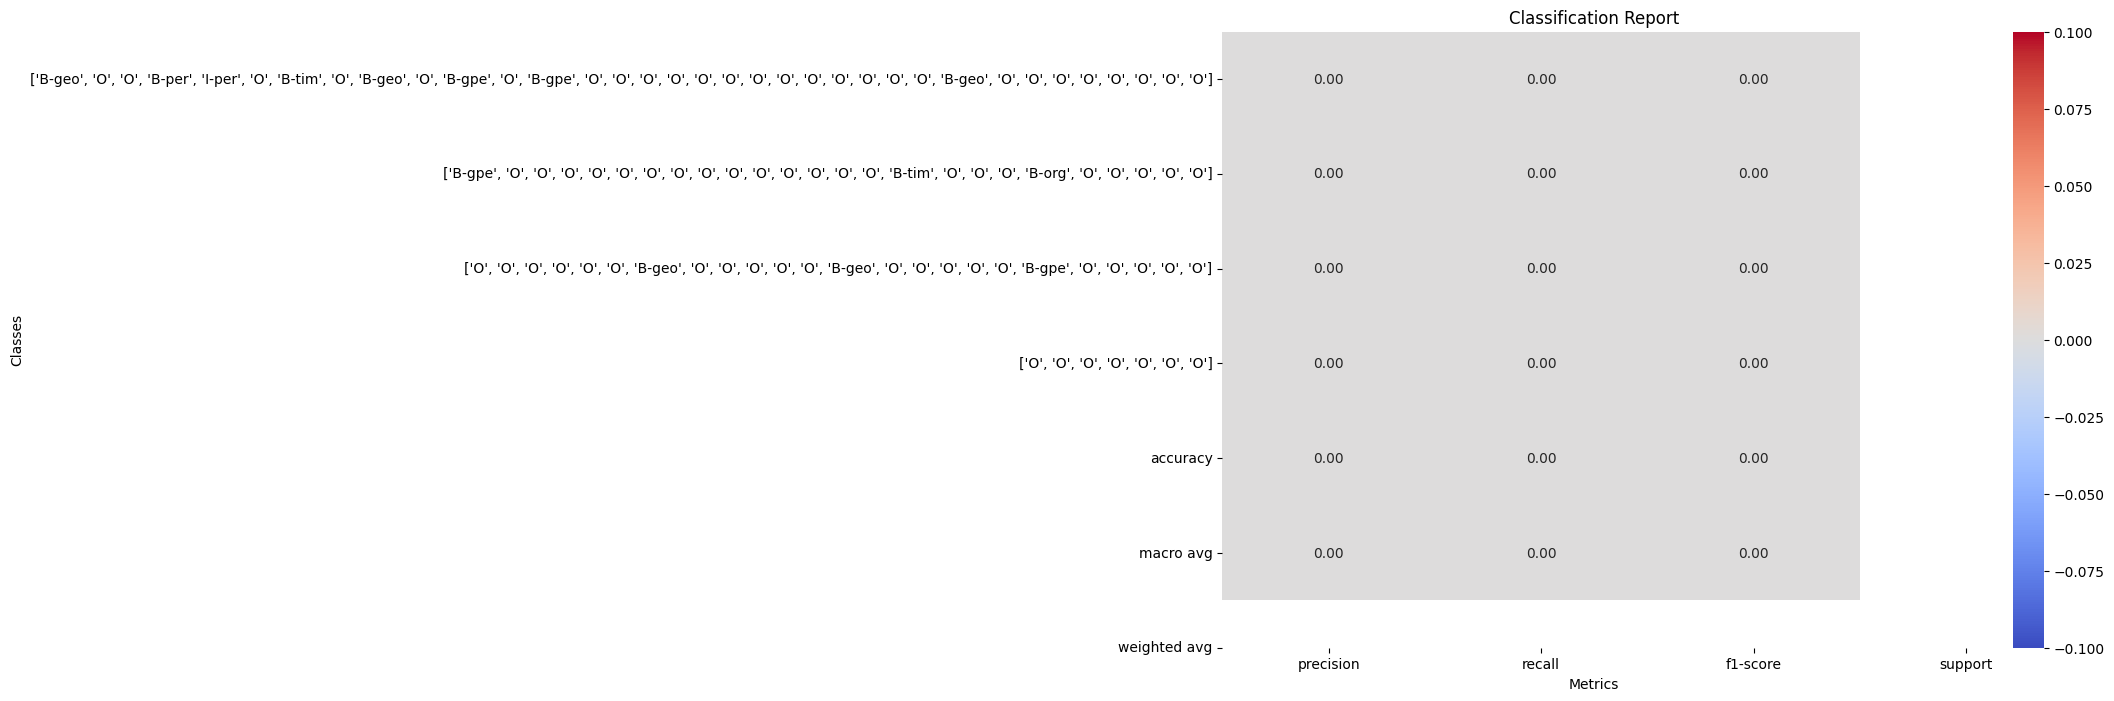

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels, labels=unique_labels, zero_division=0, output_dict=True)

# Convert classification report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Plotting the classification report
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='coolwarm', fmt='.2f', cbar=True,
            xticklabels=report_df.columns, yticklabels=report_df.index)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.show()


**5.2  Visualizing the Confusion Matrix**

We'll use seaborn to create a heatmap for the confusion matrix.

Confusion Matrix:
                                                     ['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-gpe', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']  \
['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-t...                                                  0                                                                                                                                                                 
['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O...                                                  1                                                                                                                                                                 
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O...                                                  0                                                                                           

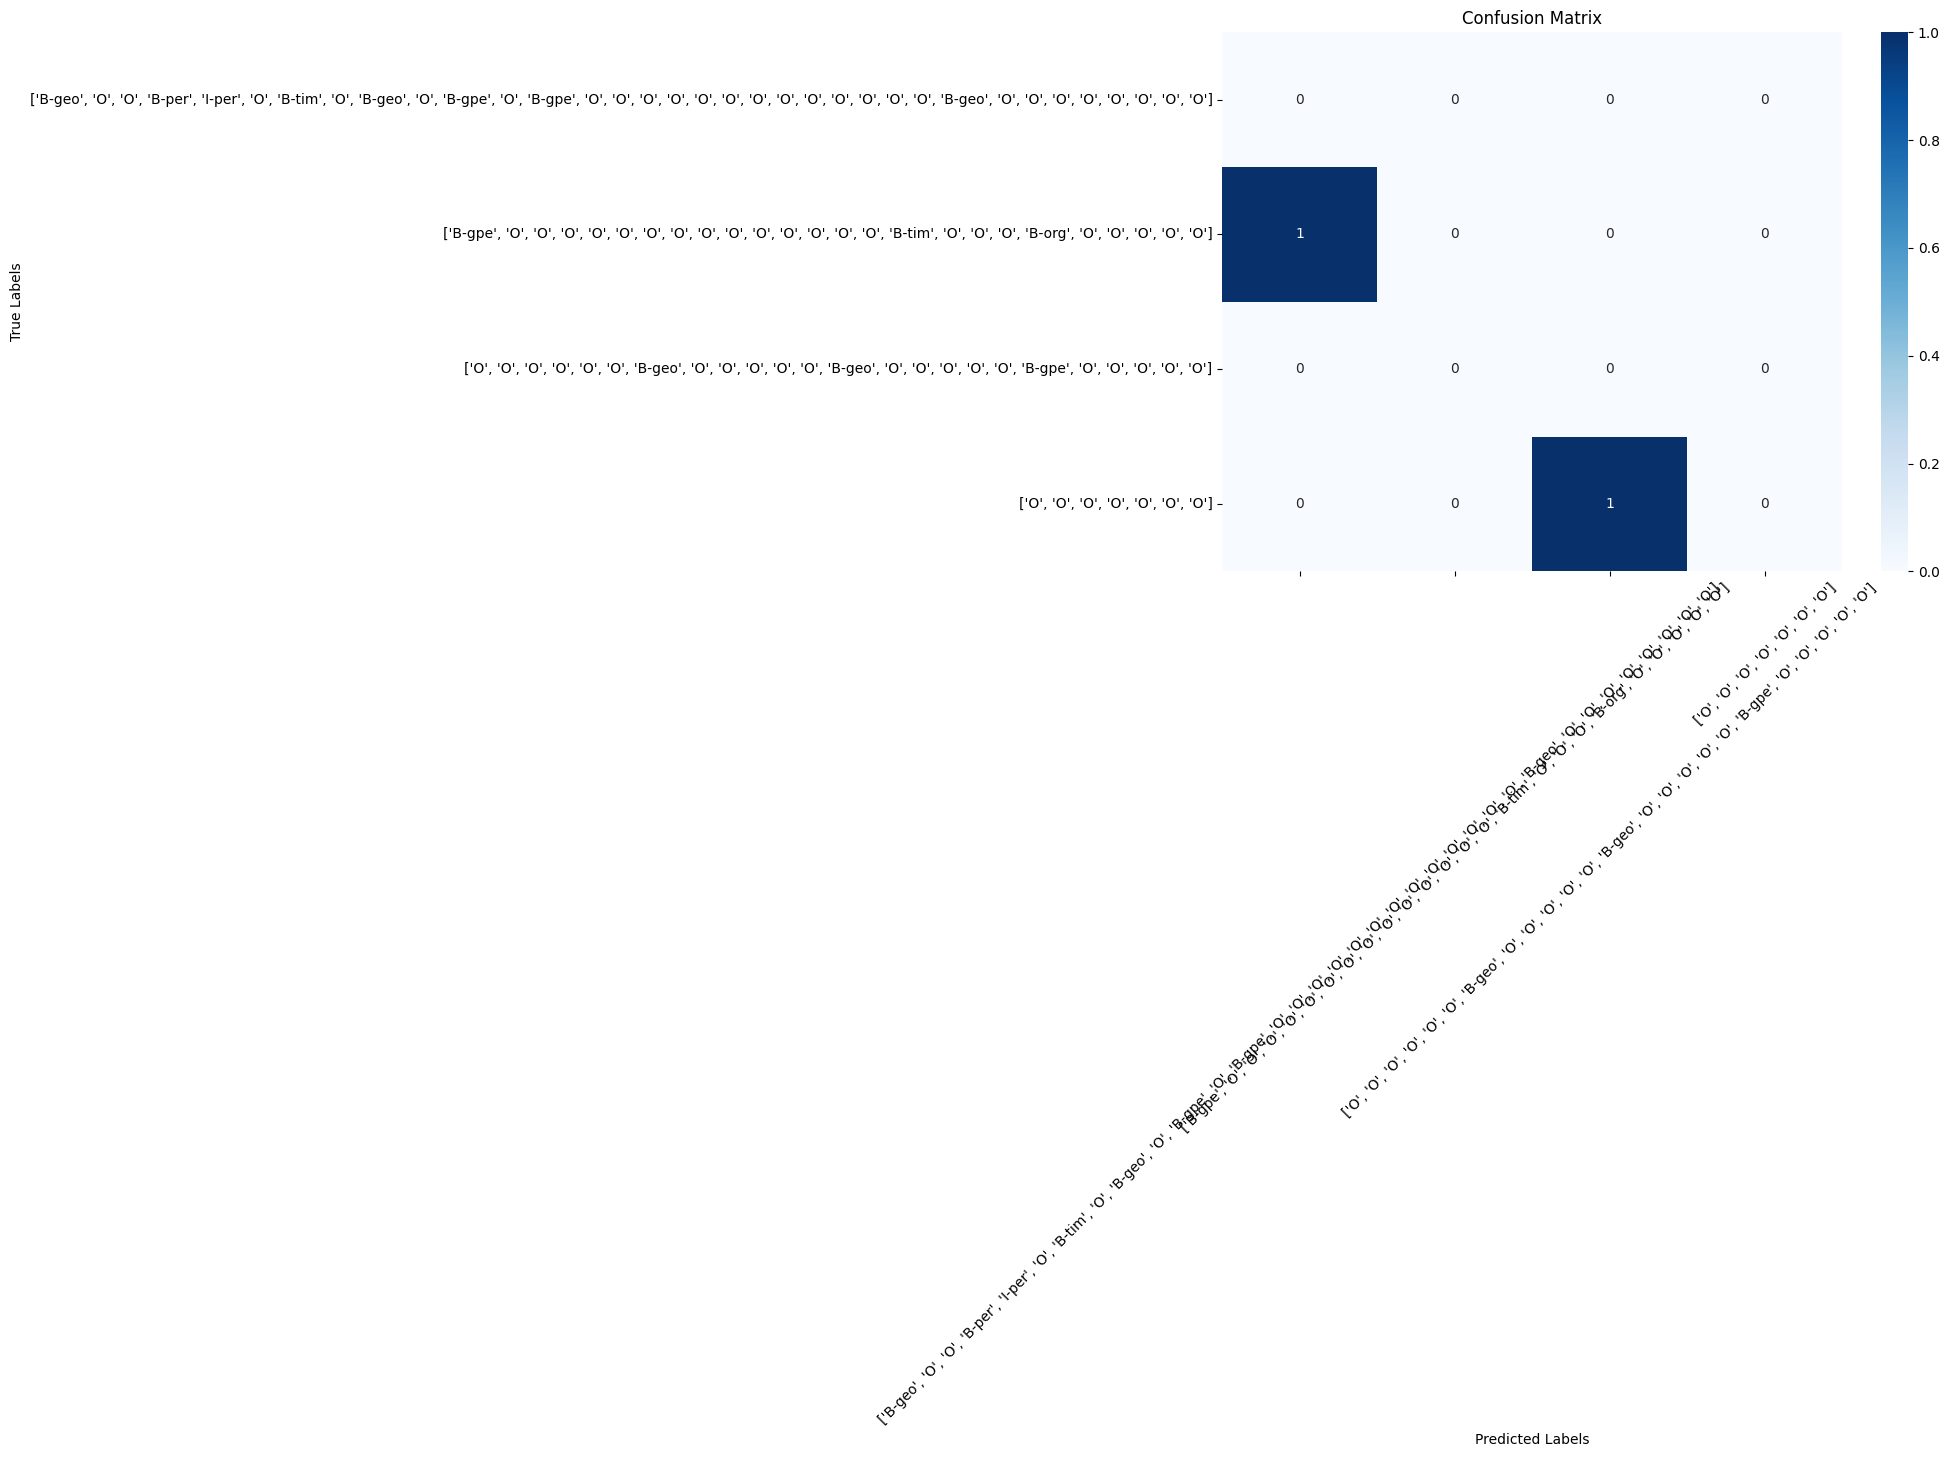

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape and content of confusion matrix
print("Confusion Matrix:\n", conf_matrix_df)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=True,
                 xticklabels=unique_labels, yticklabels=unique_labels)

# Titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Rotate labels if necessary
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()
